# **A Residual Deep Learning Method for Accurate and Efficient Recognition of Gym Exercise Activities**

In [27]:
import os
import numpy as np
import pickle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras.layers import Input, Layer, Conv1D, MaxPool1D, ReLU, BatchNormalization, LayerNormalization, Dropout, Add, Dense, GlobalMaxPooling1D, Bidirectional, GRU

In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

%run ../sys_configs.ipynb
%run ../plots.ipynb

Mounted at /content/drive


This paper is the only paper considered in this research that is tested on the MyoGym dataset. It introduces the CNN-ResBiGRU architecture which integrates *convolutional neural networks, residual connections,
and bidirectional gated recurrent units*. The paper tests this method and a range of other benchmark methods on various permutations of the sensors available in the MyoGym data.

The network begins with a convolutional block comprising a 1D convolutional layer, then a batch normalisation layer, then a max-pooling layer and finally a dropout layer.

Next, the time series is read into the ResBiGRU block. The Gated Recurrent Unit (GRU) component of the block was originally developed for tackling the vanishing gradient problem by modelling long-range temporal contexts. The paper uses GRUs rather than LSTMs because LSTMs have high memory usage and require dedicated memory cells, whereas GRUs only have update and reset gates that determine which information is kept and discarded. Because the value of the time series can be assumed to be dependent on both previous and succeeding events, this GRU model is *Bi*-directional.   

Whilst GRUs do tackle the vanishing gradient problem, it returns when modelling several ResBiGRU blocks. Therefore, a residual component is included which adds the data before and after the GRU to help enable gradient flow. There are 2 GRU layers in a ResBiGRU block, and the second layer is succeeded by a layer normalisation layer.

After the ResBiGRU blocks, the network applies a dense layer and a softmax function to output the final probabilities for each class.

In [3]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [4]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.int32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.int32)
test_labels_tf = tf.one_hot(y_test, 31, dtype=tf.int32)

In [5]:
# Convert the dataset to tensors
train_data_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
val_data_tf = tf.convert_to_tensor(x_val, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data_tf, train_labels_tf))
val_ds = tf.data.Dataset.from_tensor_slices((val_data_tf, val_labels_tf))
test_ds = tf.data.Dataset.from_tensor_slices((test_data_tf, test_labels_tf))

In [7]:
train_ds = train_ds.shuffle(500)

train_ds = train_ds.padded_batch(64)
val_ds = val_ds.padded_batch(64)
test_ds = test_ds.padded_batch(64)

In [8]:
C = len(set(y_train)) # Number of classes

### **Architecture**

We first define the convolutional block. The paper does not specify appropriate hyperparameters to use, but there are 2 obvious hyperparameters in this block: `num_filters` and `kernel_size`.

In [9]:
class ConvBlock(Layer):

    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.conv = Conv1D(self.num_filters, kernel_size=10, strides = 1, padding="same")
        self.batch_norm = BatchNormalization()
        self.max_pool = MaxPool1D(pool_size=3, strides=1, padding="same")
        self.dropout = Dropout(0.25)

    def call(self, input):
        x = self.conv(input)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        output = self.dropout(x)
        return output

Define the ResBiGRU block which is the centerpiece idea of this benchmark method.

In [10]:
class ResBiGRU(Layer):

    def __init__(self, h1_units, h2_units, **kwargs):
        super().__init__(**kwargs)
        self.h1_units = h1_units
        self.h2_units = h2_units

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.gru_1 =  Bidirectional(GRU(self.h1_units, activation = None, return_sequences=True), merge_mode=None)
        self.gru_2a = GRU(self.h2_units, activation = None, return_sequences=True)
        self.gru_2b = GRU(self.h2_units, activation = None, return_sequences=True)
        self.layer_norm = LayerNormalization()

    def call(self, input):
        # In the first (hidden) RNN layer, apply the forward and backward GRU layers concurrently
        z_forward, z_backward = self.gru_1(input)

        # In the second (hidden) RNN layer, apply the forward and backward GRU layers separately
        z2_forward = self.gru_2a(z_forward)
        z2_backward = self.gru_2b(z_backward)

        # Add the output of the first RNN layer to the output of the second RNN layer
        z_forward = Add()([z_forward, z2_forward])
        z_backward = Add()([z_backward, z2_backward])

        z_forward = self.layer_norm(z_forward)
        z_backward = self.layer_norm(z_backward)

        output = tf.concat([z_forward, z_backward], axis = 2)
        return output

Now, put together the network from the convolutional block, the ResBiGRU blocks and dense layers.

In [11]:
# We use early stopping as CNNResBiGRU is a high parameter network, so requires many epochs to train.
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# The previous benchmark paper also made use of ReduceLROnPlateau which reduces the lesrning rate when the loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=10e-5)

We will test a few different models with slightly different configurations.

#### **Model 1**

This model has 3 ResBiGRU blocks, each with the same number of hidden units. Each block has 32 hidden units.

In [12]:
def CNNResBiGRU_1(shape):
    block1_input_layer = Input(shape=shape)

    layer = ConvBlock(num_filters = 32, name = "ConvBlock")(block1_input_layer)

    # The ResBIGRU blocks is repeated several times; the architecture extensively factors in the gradient vanishing problem.
    layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(layer)
    layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU2")(layer)
    layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU3")(layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [13]:
CNNResBiGRU_model_1 = CNNResBiGRU_1(shape = (sz, dim))
CNNResBiGRU_model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ConvBlock (ConvBlock)                │ (None, 150, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU1 (ResBiGRU)                 │ (None, 150, 64)             │          25,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU2 (ResBiGRU)                 │ (None, 150, 64)             │          31,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU3 (ResBiGRU)                 │ (None, 150, 64)             │          31,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 31)                  │           2,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,607 (361.75 KB)

 Trainable params: 92,543 (361.50 KB)

 Non-trainable params: 64 (256.00 B)

In [14]:
CNNResBiGRU_model_1 = CNNResBiGRU_1(shape = (sz, dim))
CNNResBiGRU_model_1.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = CNNResBiGRU_model_1.fit(train_ds, validation_data=val_ds, epochs=25, verbose = 1)

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2436 - loss: 2.9099 - val_accuracy: 0.4777 - val_loss: 1.5540
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6323 - loss: 1.3143 - val_accuracy: 0.6573 - val_loss: 1.0374
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7707 - loss: 0.8405 - val_accuracy: 0.7371 - val_loss: 0.8270
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8718 - loss: 0.5335 - val_accuracy: 0.7428 - val_loss: 0.7417
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9160 - loss: 0.3604 - val_accuracy: 0.7328 - val_loss: 0.7183
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9538 - loss: 0.2328 - val_accuracy: 0.7443 - val_loss: 0.6857
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9676 - loss: 0.1729 - val_accuracy: 0.7364 - val_loss: 0.7508
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9775 - loss: 0.1300 - val_accuracy: 0.7270 - val_loss

In [15]:
CNNResBiGRU_model_1.save('../models/CNNResBiGRU_model/CNNResBiGRU_model_1.keras')
with open('../models/CNNResBiGRU_model/train_history_1.pkl', 'wb') as f:
    pickle.dump(history_1.history, f)

In [16]:
# Load the model
custom_objects = {'ConvBlock': ConvBlock, 'ResBiGRU': ResBiGRU}
CNNResBiGRU_model_1 = load_model('../models/CNNResBiGRU_model/CNNResBiGRU_model_1.keras', custom_objects=custom_objects)

# Load the training history
with open('../models/CNNResBiGRU_model/train_history_1.pkl', 'rb') as f:
    history_1 = pickle.load(f)

In [17]:
CNNResBiGRU_1_results = CNNResBiGRU_model_1.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*CNNResBiGRU_1_results))

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.7390 - loss: 0.9333
Validation Loss: 0.8824509382247925
Validation Accuracy: 0.7485632300376892


#### **Model 2**

This model has just 2 ResBiGRU blocks, but each block has GRUs with more dimensions.

In [12]:
def CNNResBiGRU_2(shape):
    block1_input_layer = Input(shape=shape)

    layer = ConvBlock(num_filters = 64, name = "ConvBlock")(block1_input_layer)

    # The ResBIGRU blocks is repeated several times; the architecture extensively factors in the gradient vanishing problem.
    layer = ResBiGRU(h1_units = 64, h2_units = 64, name = "ResBiGRU1")(layer)
    layer = ResBiGRU(h1_units = 64, h2_units = 64, name = "ResBiGRU2")(layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [13]:
CNNResBiGRU_model_2 = CNNResBiGRU_2(shape = (sz, dim))
CNNResBiGRU_model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ConvBlock (ConvBlock)                │ (None, 150, 64)             │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU1 (ResBiGRU)                 │ (None, 150, 128)            │          99,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU2 (ResBiGRU)                 │ (None, 150, 128)            │         124,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,671 (908.87 KB)

 Trainable params: 232,543 (908.37 KB)

 Non-trainable params: 128 (512.00 B)

In [20]:
CNNResBiGRU_model_2 = CNNResBiGRU_2(shape = (sz, dim))
CNNResBiGRU_model_2.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = CNNResBiGRU_model_2.fit(train_ds, validation_data=val_ds, epochs=25, verbose = 1, callbacks=[earlystopping, reduce_lr])

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.3292 - loss: 2.4917 - val_accuracy: 0.6674 - val_loss: 1.1346 - learning_rate: 0.0010
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7508 - loss: 0.8207 - val_accuracy: 0.6925 - val_loss: 0.8569 - learning_rate: 0.0010
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8908 - loss: 0.4383 - val_accuracy: 0.7687 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9491 - loss: 0.2293 - val_accuracy: 0.7687 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9725 - loss: 0.1397 - val_accuracy: 0.7787 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9712 - loss: 0.1126 - val_accuracy: 0.7522 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9883 - loss: 0.0662 - val_accurac

In [21]:
CNNResBiGRU_model_2.save('../models/CNNResBiGRU_model/CNNResBiGRU_model_2.keras')
with open('../models/CNNResBiGRU_model/train_history_2.pkl', 'wb') as f:
    pickle.dump(history_2.history, f)

In [14]:
# Load the model
custom_objects = {'ConvBlock': ConvBlock, 'ResBiGRU': ResBiGRU}
CNNResBiGRU_model_2 = load_model('../models/CNNResBiGRU_model/CNNResBiGRU_model_2.keras', custom_objects=custom_objects)

# Load the training history
with open('../models/CNNResBiGRU_model/train_history_2.pkl', 'rb') as f:
    history_2 = pickle.load(f)

In [15]:
CNNResBiGRU_2_results = CNNResBiGRU_model_2.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*CNNResBiGRU_2_results))

22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 596ms/step - accuracy: 0.7497 - loss: 0.6832
Validation Loss: 0.6581740975379944
Validation Accuracy: 0.7622126340866089


#### **Model 3**

This model has fewer parameters than either model 1 or model 2, intended to encourage the model to learn a more compact feature representation.

In [24]:
def CNNResBiGRU_3(shape):
    block1_input_layer = Input(shape=shape)

    layer = ConvBlock(num_filters = 32, name = "ConvBlock")(block1_input_layer)

    # The ResBIGRU blocks is repeated several times; the architecture extensively factors in the gradient vanishing problem.
    layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(layer)

    layer = GlobalMaxPooling1D()(layer)
    output_layer = Dense(C, activation="softmax")(layer)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [25]:
CNNResBiGRU_model_3 = CNNResBiGRU_3(shape = (sz, dim))
CNNResBiGRU_model_3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 150, 6)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ConvBlock (ConvBlock)                │ (None, 150, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ResBiGRU1 (ResBiGRU)                 │ (None, 150, 64)             │          25,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 31)                  │           2,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,503 (115.25 KB)

 Trainable params: 29,439 (115.00 KB)

 Non-trainable params: 64 (256.00 B)

In [38]:
CNNResBiGRU_model_3 = CNNResBiGRU_3(shape = (sz, dim))
CNNResBiGRU_model_3.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = CNNResBiGRU_model_3.fit(train_ds, validation_data=val_ds, epochs=25, verbose = 1, callbacks=[earlystopping, reduce_lr])

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.1826 - loss: 3.2340 - val_accuracy: 0.4404 - val_loss: 1.9432 - learning_rate: 0.0010
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.5205 - loss: 1.6916 - val_accuracy: 0.5474 - val_loss: 1.4236 - learning_rate: 0.0010
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.6476 - loss: 1.2527 - val_accuracy: 0.5984 - val_loss: 1.1462 - learning_rate: 0.0010
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.7285 - loss: 0.9690 - val_accuracy: 0.6358 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.7863 - loss: 0.7652 - val_accuracy: 0.6667 - val_loss: 0.8618 - learning_rate: 0.0010
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.8308 - loss: 0.6034 - val_accuracy: 0.6602 - val_loss: 0.8381 - learning_rate: 0.0010
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 379ms/step - accuracy: 0.8861 - loss: 0.

In [39]:
CNNResBiGRU_model_3.save('../models/CNNResBiGRU_model/CNNResBiGRU_model_3.keras')
with open('../models/CNNResBiGRU_model/train_history_3.pkl', 'wb') as f:
    pickle.dump(history_3.history, f)

In [40]:
# Load the model
custom_objects = {'ConvBlock': ConvBlock, 'ResBiGRU': ResBiGRU}
CNNResBiGRU_model_3 = load_model('../models/CNNResBiGRU_model/CNNResBiGRU_model_3.keras', custom_objects=custom_objects)

# Load the training history
with open('../models/CNNResBiGRU_model/train_history_3.pkl', 'rb') as f:
    history_3 = pickle.load(f)

In [41]:
CNNResBiGRU_3_results = CNNResBiGRU_model_3.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*CNNResBiGRU_3_results))

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.6787 - loss: 0.9031
Validation Loss: 0.8462604880332947
Validation Accuracy: 0.7083333134651184


#### **Model 4**

The final model tested is the largest of the 4 models considered, and has 5 ResBiGRU blocks and an additional residual connection *between* consecutive blocks.

In [12]:
def CNNResBiGRU_4(shape):
    block1_input_layer = Input(shape=shape)

    z = ConvBlock(num_filters = 64, name = "ConvBlock")(block1_input_layer)

    # The ResBIGRU blocks is repeated several times; the architecture extensively factors in the gradient vanishing problem.
    z1 = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(z)
    z = Add()([z, z1])

    z2 = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU2")(z)
    z = Add()([z, z2])

    z3 = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU3")(z)
    z = Add()([z, z3])

    z4 = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU4")(z)
    z = Add()([z, z4])

    z5 = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU5")(z)
    z = Add()([z, z5])

    z = GlobalMaxPooling1D()(z)
    output_layer = Dense(C, activation="softmax")(z)
    return Model(inputs=block1_input_layer, outputs=output_layer)

In [13]:
CNNResBiGRU_model_4 = CNNResBiGRU_4(shape = (sz, dim))
CNNResBiGRU_model_4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock (ConvBlock)     │ (None, 150, 64)        │          4,160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU1 (ResBiGRU)      │ (None, 150, 64)        │         31,552 │ ConvBlock[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 150, 64)        │              0 │ ConvBlock[0][0],       │
│                           │                        │                │ ResBiGRU1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU2 (ResBiGRU)      │ (None, 150, 64)        │         31,552 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 150, 64)        │              0 │ add_2[0][0],           │
│                           │                        │                │ ResBiGRU2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU3 (ResBiGRU)      │ (None, 150, 64)        │         31,552 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 150, 64)        │              0 │ add_5[0][0],           │
│                           │                        │                │ ResBiGRU3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU4 (ResBiGRU)      │ (None, 150, 64)        │         31,552 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 150, 64)        │              0 │ add_8[0][0],           │
│                           │                        │                │ ResBiGRU4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU5 (ResBiGRU)      │ (None, 150, 64)        │         31,552 │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 150, 64)        │              0 │ add_11[0][0],          │
│                           │                        │                │ ResBiGRU5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ add_14[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 31)             │          2,015 │ global_max_pooling1d[… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 163,935 (640.37 KB)

 Trainable params: 163,807 (639.87 KB)

 Non-trainable params: 128 (512.00 B)

In [14]:
CNNResBiGRU_model_4 = CNNResBiGRU_4(shape = (sz, dim))
CNNResBiGRU_model_4.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.99, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = CNNResBiGRU_model_4.fit(train_ds, validation_data=val_ds, epochs=25, verbose = 1, callbacks=[earlystopping, reduce_lr])

Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 113s 967ms/step - accuracy: 0.2576 - loss: 4.1048 - val_accuracy: 0.5496 - val_loss: 1.3313 - learning_rate: 0.0010
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - accuracy: 0.6804 - loss: 0.8871 - val_accuracy: 0.6372 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 603ms/step - accuracy: 0.8577 - loss: 0.4741 - val_accuracy: 0.6588 - val_loss: 0.9064 - learning_rate: 0.0010
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 602ms/step - accuracy: 0.9135 - loss: 0.3199 - val_accuracy: 0.7342 - val_loss: 0.7271 - learning_rate: 0.0010
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - accuracy: 0.9485 - loss: 0.2106 - val_accuracy: 0.7205 - val_loss: 0.7581 - learning_rate: 0.0010
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9649 - loss: 0.1506 - val_accuracy: 0.7421 - val_loss: 0.7716 - learning_rate: 0.0010
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 604ms/step - accuracy: 0.9819 - loss: 0

In [15]:
CNNResBiGRU_model_4.save('../models/CNNResBiGRU_model/CNNResBiGRU_model_4.keras')
with open('../models/CNNResBiGRU_model/train_history_4.pkl', 'wb') as f:
    pickle.dump(history_4.history, f)

In [16]:
# Load the model
custom_objects = {'ConvBlock': ConvBlock, 'ResBiGRU': ResBiGRU}
CNNResBiGRU_model_4 = load_model('../models/CNNResBiGRU_model/CNNResBiGRU_model_4.keras', custom_objects=custom_objects)

# Load the training history
with open('../models/CNNResBiGRU_model/train_history_4.pkl', 'rb') as f:
    history_4 = pickle.load(f)

In [17]:
CNNResBiGRU_4_results = CNNResBiGRU_model_4.evaluate(val_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*CNNResBiGRU_4_results))

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.7590 - loss: 0.7702
Validation Loss: 0.6976298093795776
Validation Accuracy: 0.7765804529190063


The takeaway from models 1-4 is that the larger models do not generalise better than small models. There is no obvious benefit to stacking more than 2 ResBiGRU blocks on the validation loss or accuracy.

### **Visualise predictions for test set**

We visualise the model with 2 ResBiGRU blocks.

In [23]:
CNNResBiGRU_2_val_predictions = CNNResBiGRU_model_2.predict(val_data_tf, batch_size=128)
CNNResBiGRU_2_test_predictions = CNNResBiGRU_model_2.predict(test_data_tf, batch_size=128)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step


In [24]:
CNNResBiGRU_2_val_predictions = tf.argmax(CNNResBiGRU_2_val_predictions, axis = 1).numpy()
CNNResBiGRU_2_test_predictions = tf.argmax(CNNResBiGRU_2_test_predictions, axis = 1).numpy()

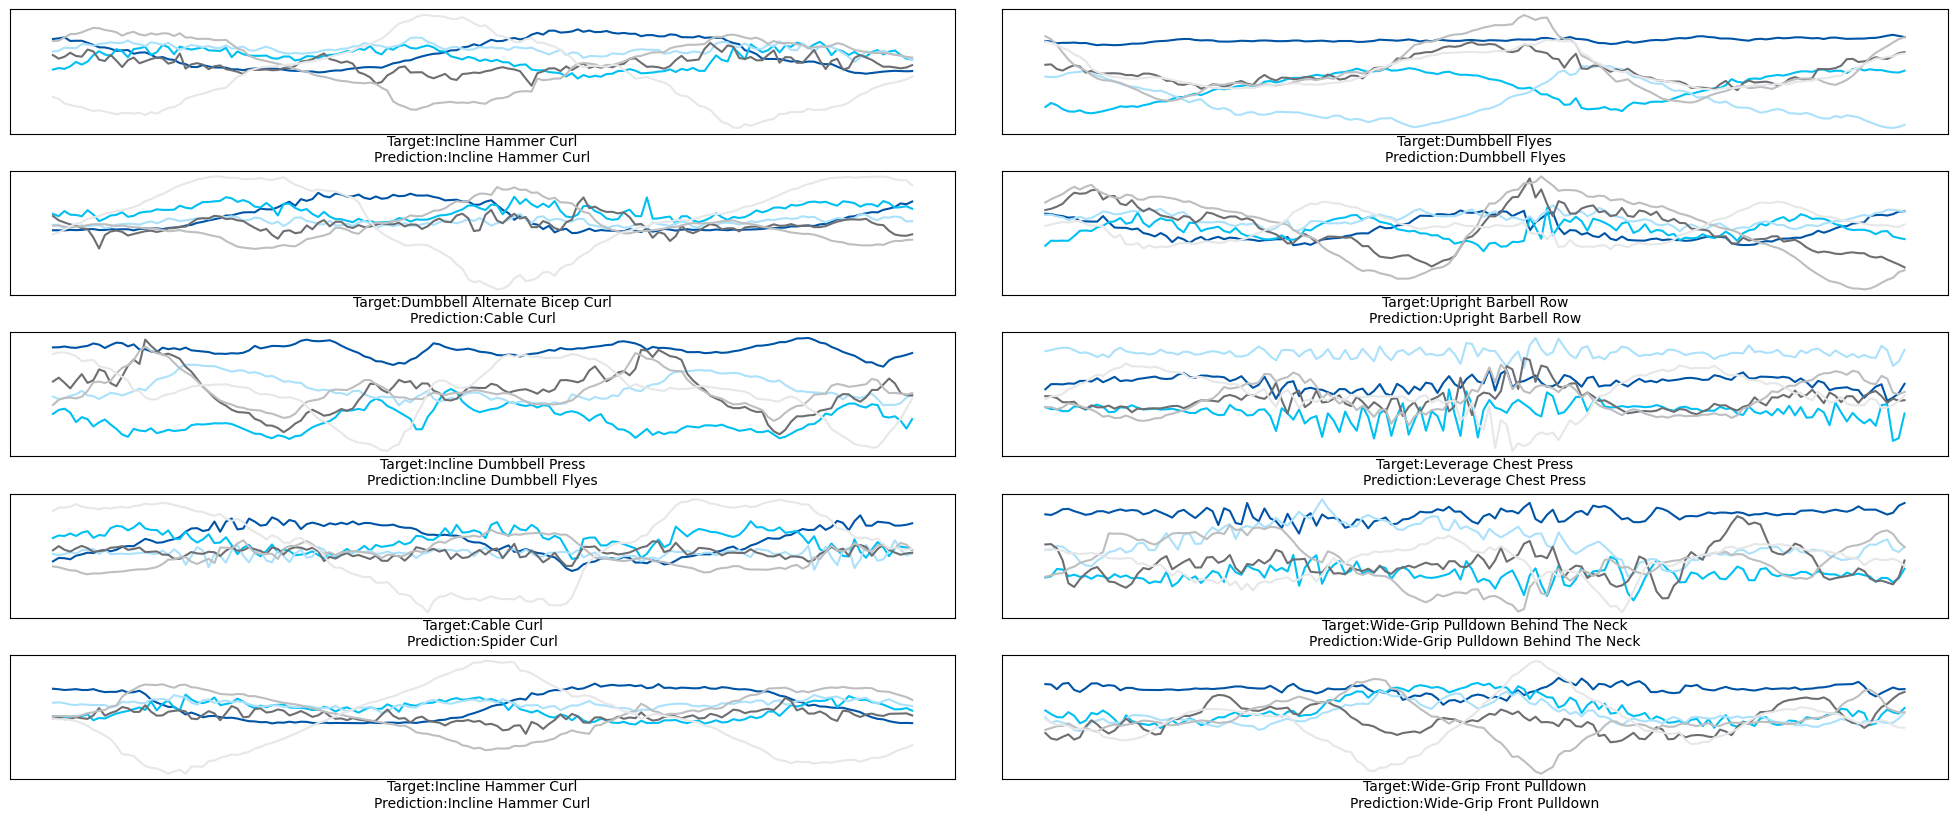

In [25]:
plot_samples(data = x_test, labels = y_test, predictions = CNNResBiGRU_2_test_predictions)

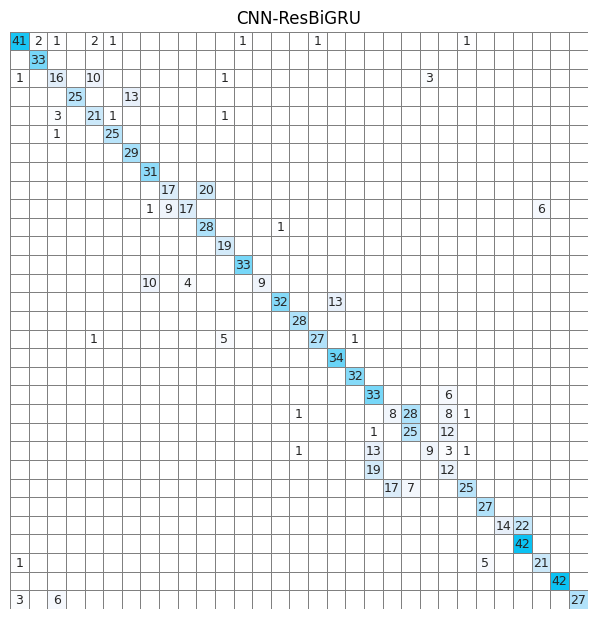

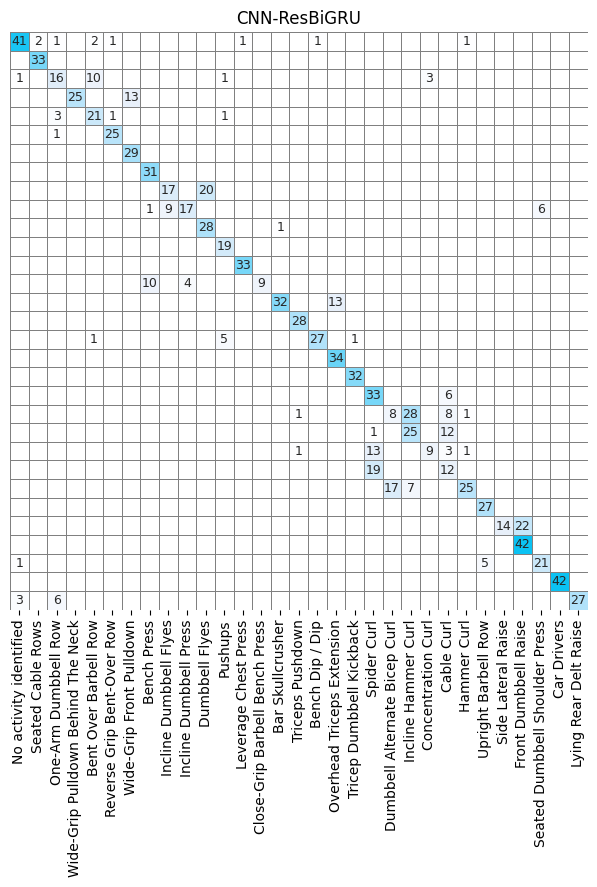

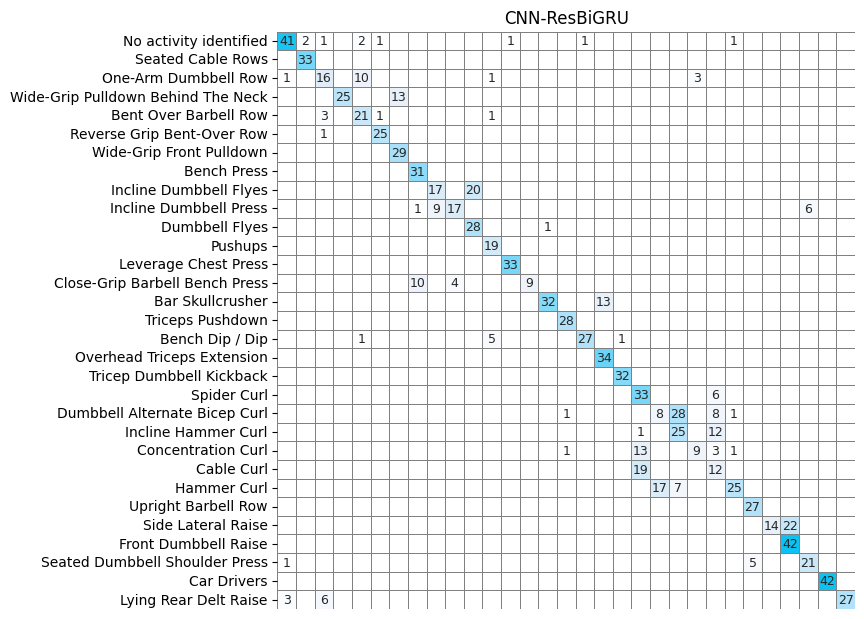

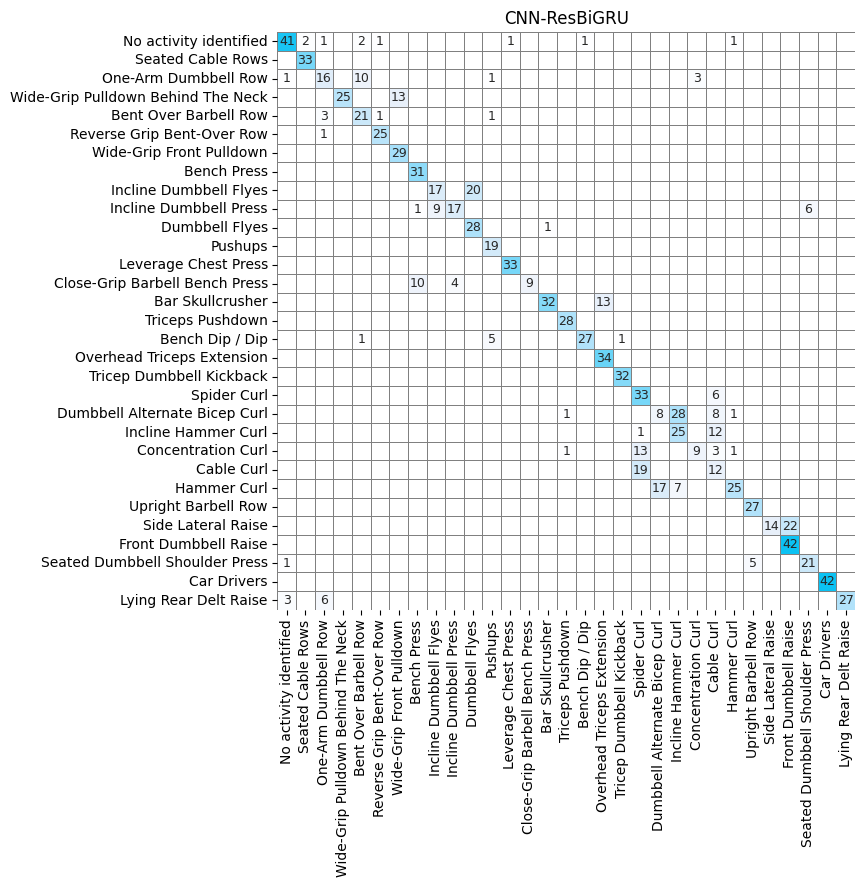

In [28]:
cm1 = confusion_matrix(y_test, CNNResBiGRU_2_test_predictions, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = False, save = True, title = "CNN-ResBiGRU")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = False, save = True, title = "CNN-ResBiGRU")
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = True, save = True, title = "CNN-ResBiGRU")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = True, save = True, title = "CNN-ResBiGRU")

## **References**

[1] Mekruksavanich, Sakorn and Anuchit Jitpattanakul. “A Residual Deep Learning Method for Accurate and Efficient Recognition of Gym Exercise Activities Using Electromyography and IMU Sensors.” Applied System Innovation (2024): n. pag.